In [1]:
import pandas as pd
df=pd.read_csv("respiratory_disease.csv")
df

date district            city  facilityid      doctorname  \
0       2019-01-04     West      Vikas Puri      310710    Dr. Ravikant   
1       2019-06-29     West     Uttam Nagar      320712  Dr. R.C.Khanna   
2       2017-04-26     West     Uttam Nagar      320720          Pramod   
3       2019-06-29     West     Uttam Nagar      320712  Dr. R.C.Khanna   
4       2019-06-28     West     Uttam Nagar      320720          Pramod   
...            ...      ...             ...         ...             ...   
337300  2017-12-19     West     Shakurbasti      150706    guest.150706   
337301  2018-05-04     West         Nangloi      110703    guest.110703   
337302  2018-02-23     West     Uttam Nagar      320721    guest.320721   
337303  2017-06-27     West  Rajouri Garden      270707    guest.270707   
337304  2017-01-25     West      Vikas Puri      310709    guest.310709   

           medongoid appointmenttime  gender   age  \
0       1.367039e+09        10:06:51       1  28.0   
1       1.367939e+09        11:18:14       0  52.0   
2       1.121171e+09        10:41:09       1   3.0   
3       1.367938e+09        12:42:33       0   6.0   
4       1.367938e+09        12:21:19       0  26.0   
...              ...             ...     ...   ...   
337300  1.354077e+09        22:22:40       0  15.0   
337301  1.125356e+09        13:14:16       1  25.0   
337302  1.053347e+09        11:33:20       1  56.0   
337303  1.284592e+09        10:39:19       1   1.3   
337304  1.025405e+09        11:15:44       1  65.0   

                                     diagnosis  is_respiratory  \
0                                ['influenza']            True   
1                    ['acute nasopharyngitis']            True   
2       ['acute upper respiratory infections']            True   
3                    ['acute nasopharyngitis']            True   
4                               ['bronchitis']            True   
...                                        ...             ...   
337300               ['acute nasopharyngitis']            True   
337301  ['acute upper respiratory infections']            True   
337302               ['acute nasopharyngitis']            True   
337303  ['acute upper respiratory infections']            True   
337304                           ['pertussis']            True   

        respiratory_diagnosis  
0                        True  
1                        True  
2                        True  
3                        True  
4                        True  
...                       ...  
337300                   True  
337301                   True  
337302                   True  
337303                   True  
337304                   True  

[337305 rows x 12 columns]

In [2]:
import ast

# Step 1: Convert the 'diagnosis' column (which is a string of lists) to actual lists
df['diagnosis'] = df['diagnosis'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Check the result
print(df['diagnosis'].head())

0                             [influenza]
1                 [acute nasopharyngitis]
2    [acute upper respiratory infections]
3                 [acute nasopharyngitis]
4                            [bronchitis]
Name: diagnosis, dtype: object


Test Data - RMSE: 45.648505017812894, R²: 0.9444358274348508, MAE: 32.30643239962001, MAPE: 7.058707657810297%
All Data - RMSE: 20.45762156960022, R²: 0.9874428225915537, MAE: 7.158048460204205, MAPE: 1.6162887558664476%


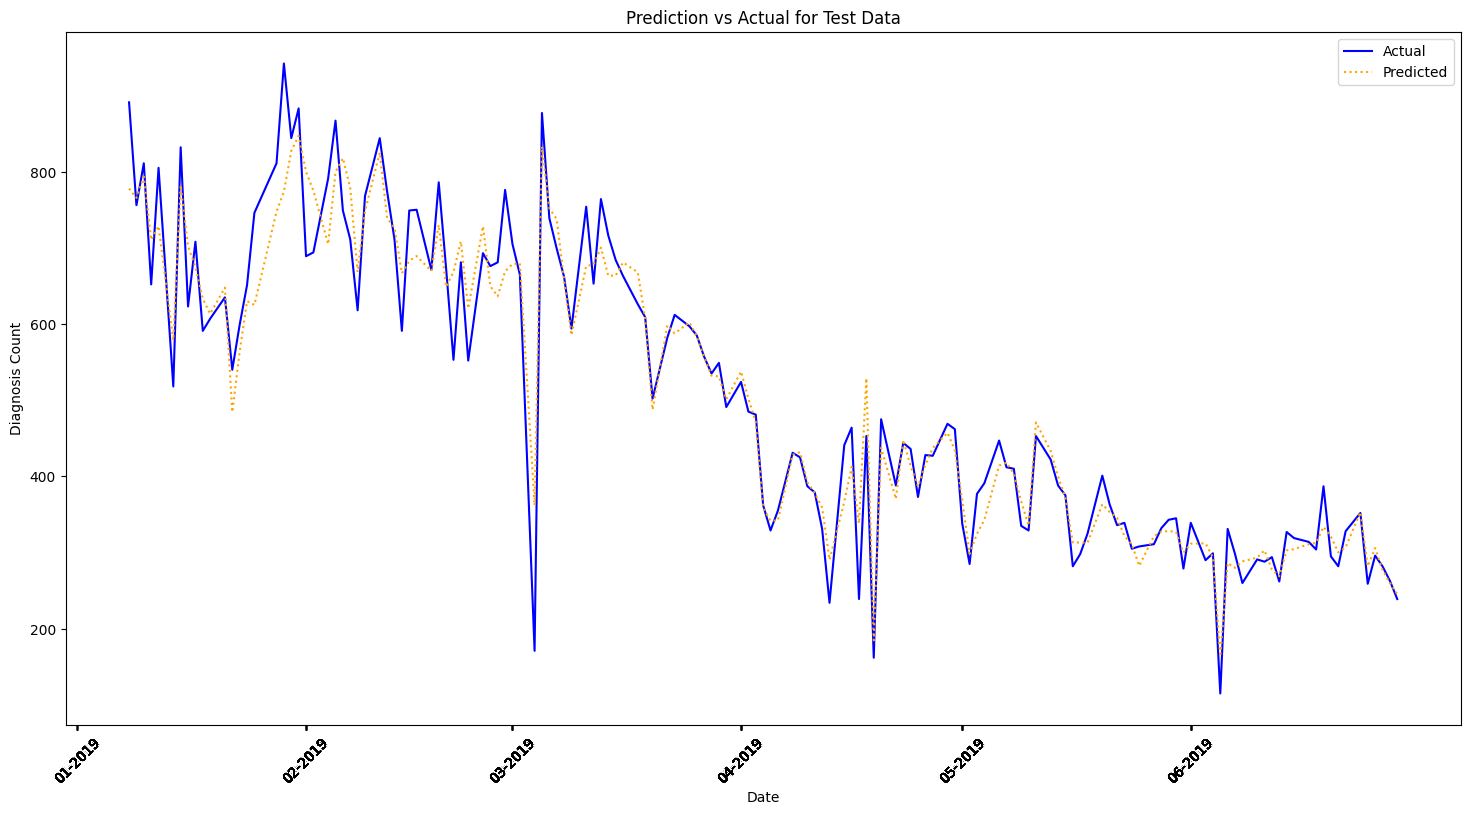

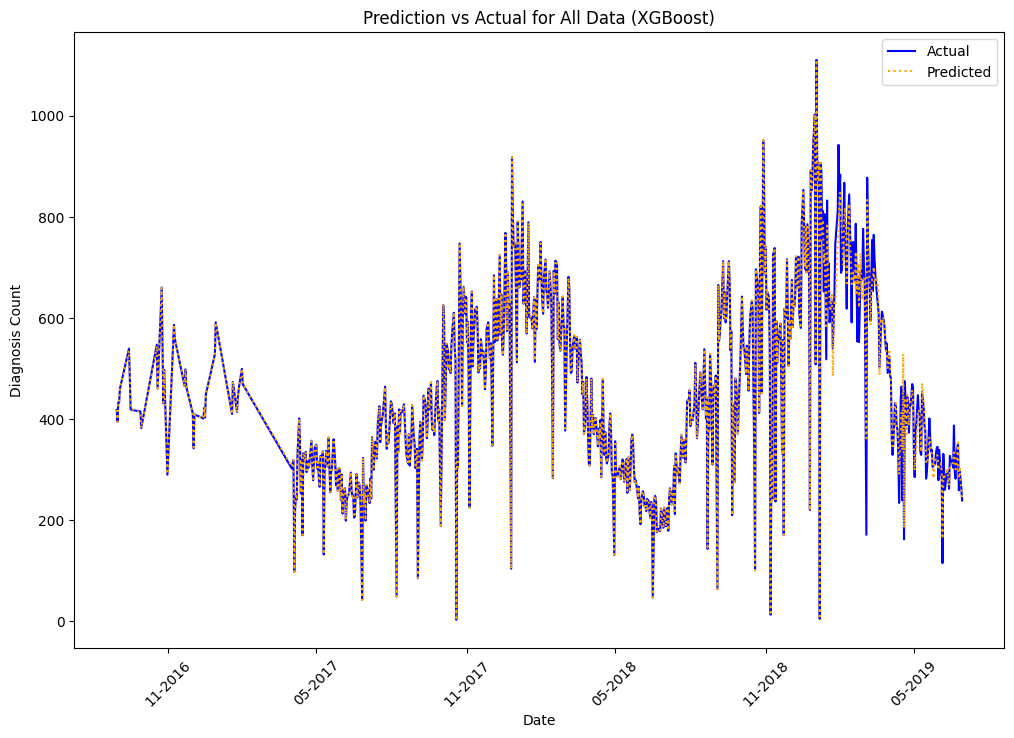

In [10]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Preprocess data
def preprocess_data(df):
    df['date'] = pd.to_datetime(df['date'])
    time_series = df.groupby('date').agg({
        'diagnosis': 'count',
        'age': 'mean',
        'gender': 'mean'
    }).reset_index()

    time_series.rename(columns={'diagnosis': 'diagnosis_count'}, inplace=True)
    time_series['month'] = time_series['date'].dt.month
    time_series['day_of_week'] = time_series['date'].dt.dayofweek
    time_series['season'] = (time_series['month'] % 12 // 3) + 1

    for lag in range(1, 7):
        time_series[f'diagnosis_count_lag_{lag}'] = time_series['diagnosis_count'].shift(lag)

    time_series['rolling_mean_3'] = time_series['diagnosis_count'].rolling(window=3).mean()
    time_series['rolling_mean_7'] = time_series['diagnosis_count'].rolling(window=7).mean()

    return time_series.dropna()

# Assuming df is already loaded as the dataset
time_series = preprocess_data(df)

# Features and target
features = ['age', 'gender', 'month', 'day_of_week', 'season'] + \
           [f'diagnosis_count_lag_{i}' for i in range(1, 7)] + \
           ['rolling_mean_3', 'rolling_mean_7']
X = time_series[features]
y = time_series['diagnosis_count']

# Train-test split
train_size = int(len(time_series) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train XGBoost
model = XGBRegressor(objective='reg:squarederror', n_estimators=300, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)

# Predictions
y_pred_test = model.predict(X_test)
y_pred_all = model.predict(X)

# Evaluation Metrics
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100

rmse_all = np.sqrt(mean_squared_error(y, y_pred_all))
r2_all = r2_score(y, y_pred_all)
mae_all = mean_absolute_error(y, y_pred_all)
mape_all = mean_absolute_percentage_error(y, y_pred_all) * 100

# Print metrics
print(f"Test Data - RMSE: {rmse_test}, R²: {r2_test}, MAE: {mae_test}, MAPE: {mape_test}%")
print(f"All Data - RMSE: {rmse_all}, R²: {r2_all}, MAE: {mae_all}, MAPE: {mape_all}%")

# Plot Prediction vs Actual for Test Data
plt.figure(figsize=(18, 9))
plt.plot(time_series['date'][train_size:], y_test, label='Actual', color='blue')
plt.plot(time_series['date'][train_size:], y_pred_test, label='Predicted', color='orange', linestyle=':')
plt.title('Prediction vs Actual for Test Data')
plt.xlabel('Date')
plt.ylabel('Diagnosis Count')
plt.xticks(time_series['date'][train_size:].dt.to_period('M').dt.to_timestamp(), 
           time_series['date'][train_size:].dt.to_period('M').dt.strftime('%m-%Y'), rotation=45)
plt.legend()
plt.show()

# Plot Prediction vs Actual for All Data
plt.figure(figsize=(12, 8))
plt.plot(time_series['date'], y, label='Actual', color='blue')
plt.plot(time_series['date'], y_pred_all, label='Predicted', color='orange', linestyle=':')
plt.title('Prediction vs Actual for All Data (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Diagnosis Count')
locator = mdates.MonthLocator(interval=6)
formatter = mdates.DateFormatter('%m-%Y')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
plt.xticks(rotation=45)
plt.legend()
plt.show()


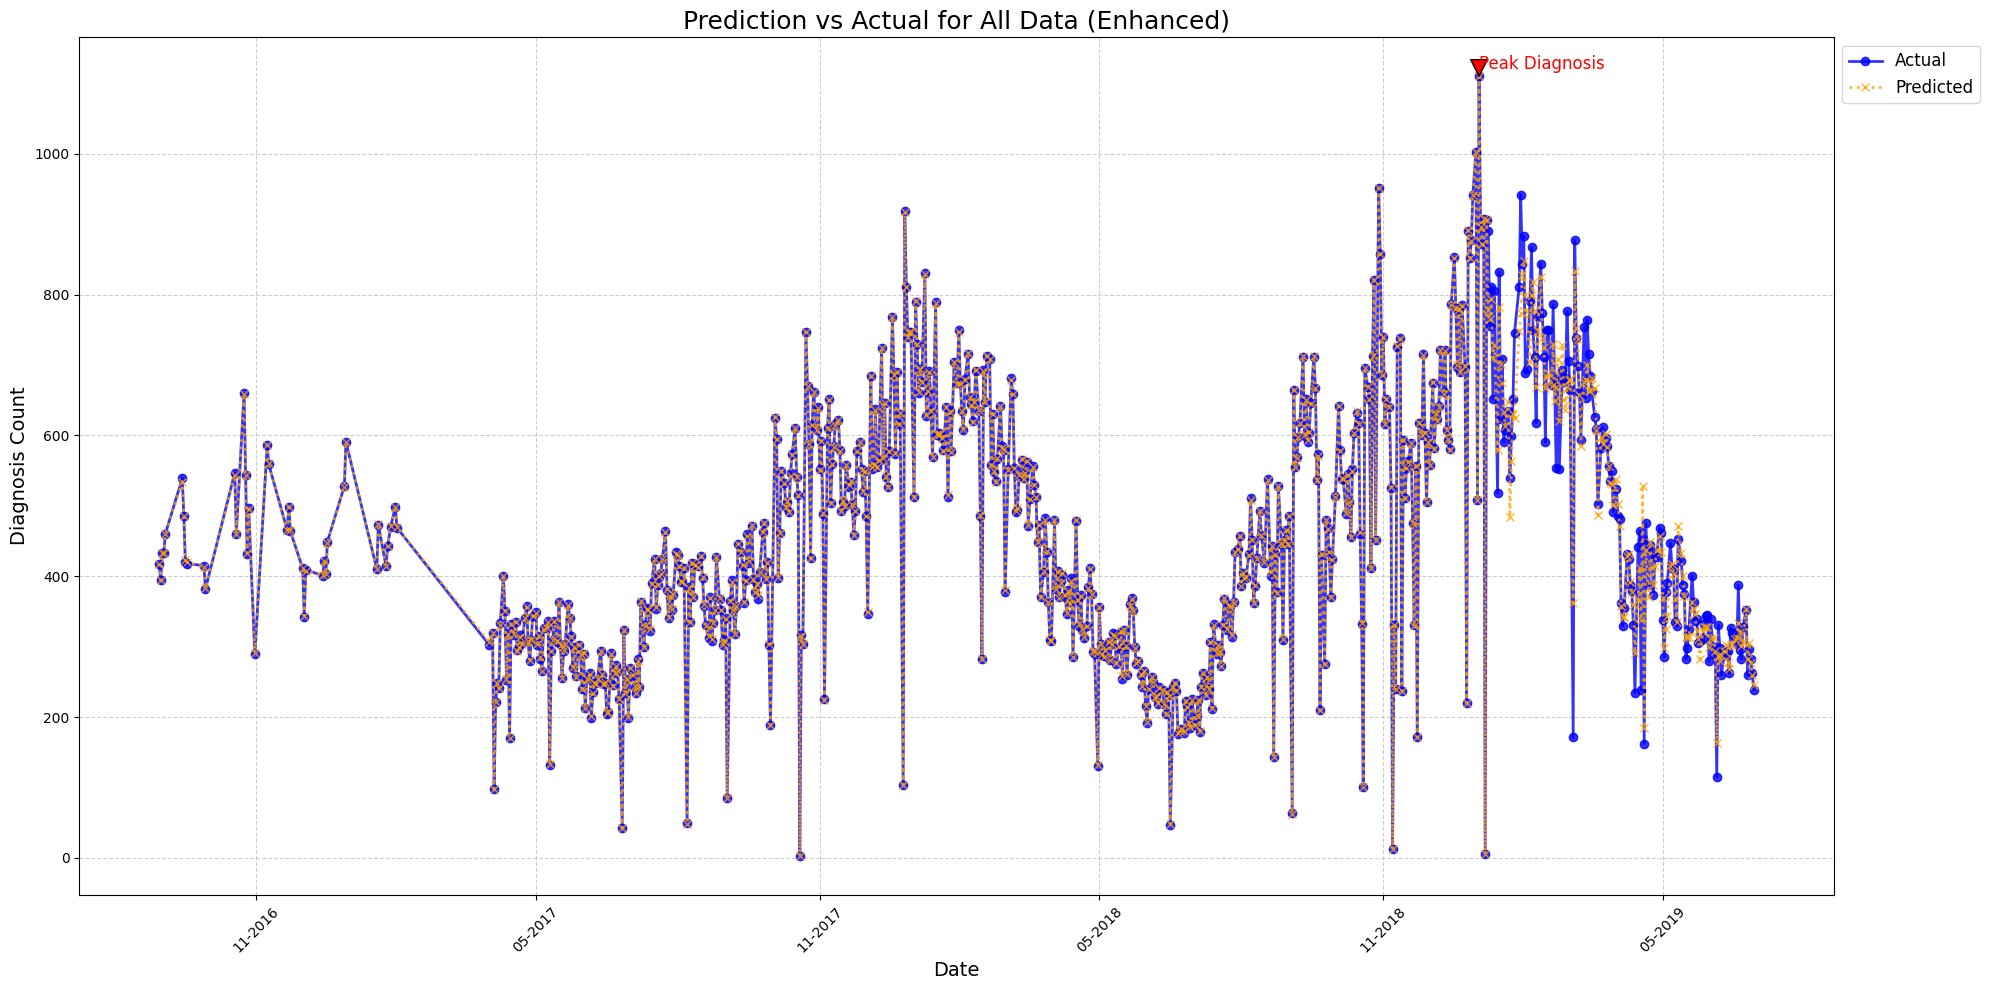

In [11]:
# Enhanced Plot for All Data
plt.figure(figsize=(20, 10))
plt.plot(time_series['date'], y, label='Actual', color='blue', linewidth=2, marker='o', alpha=0.8)
plt.plot(time_series['date'], y_pred_all, label='Predicted', color='orange', linestyle=':', linewidth=2, marker='x', alpha=0.8)

# Title & Labels
plt.title('Prediction vs Actual for All Data (Enhanced)', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Diagnosis Count', fontsize=14)

# X-axis ticks every 6 months
locator = mdates.MonthLocator(interval=6)
formatter = mdates.DateFormatter('%m-%Y')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

# Grid & Annotations
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)

# Enhanced Legend
plt.legend(loc='upper left', fontsize=12, bbox_to_anchor=(1, 1))
plt.tight_layout()

# Example Annotation
max_idx = y.idxmax()
plt.annotate('Peak Diagnosis', xy=(time_series['date'][max_idx], y[max_idx]),
             xytext=(time_series['date'][max_idx], y[max_idx] + 10),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=12, color='red')

plt.show()


Test Data - RMSE: 45.648505017812894, R²: 0.9444358274348508
All Data - RMSE: 20.45762156960022, R²: 0.9874428225915537


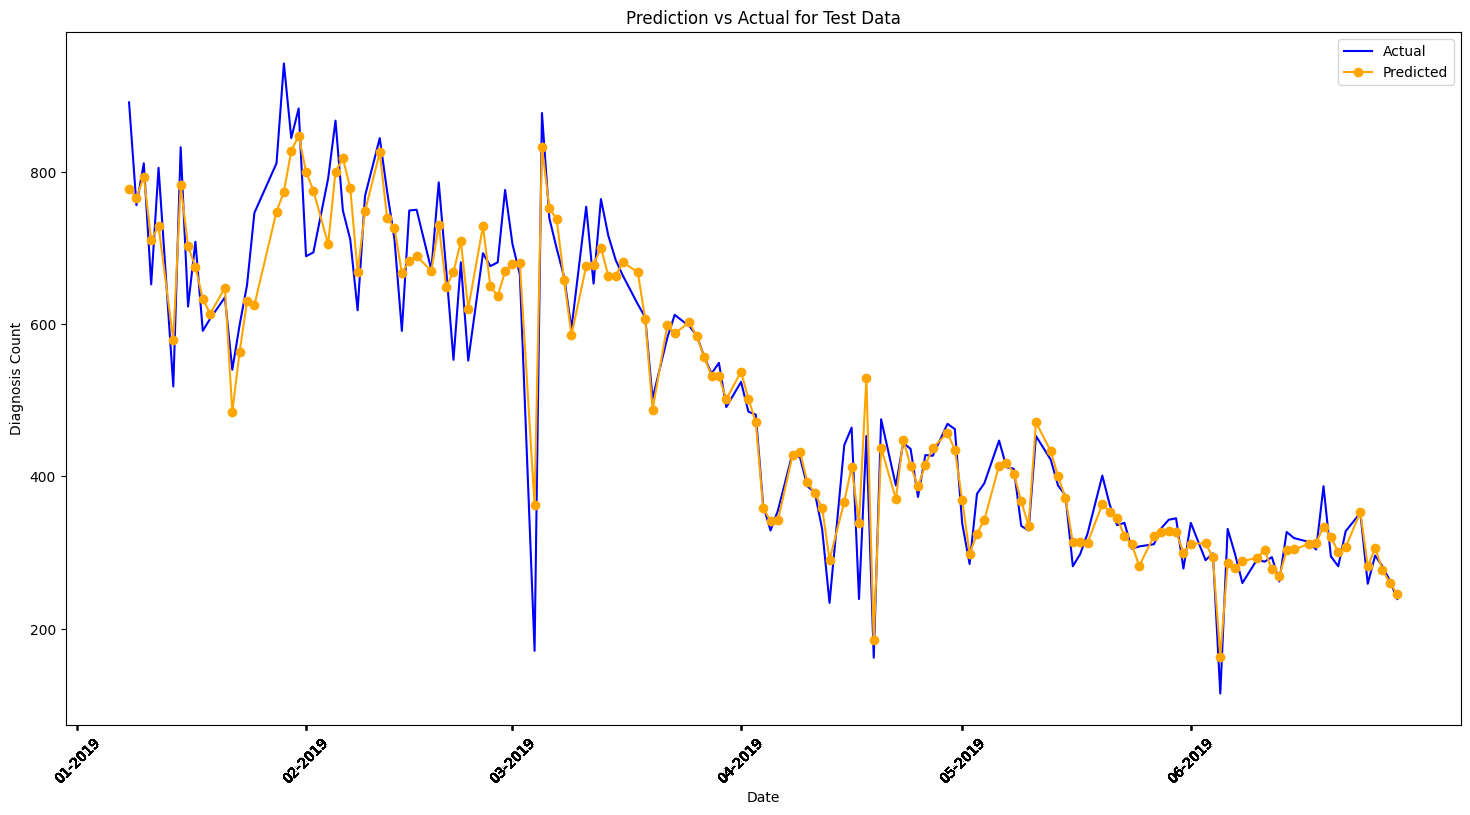

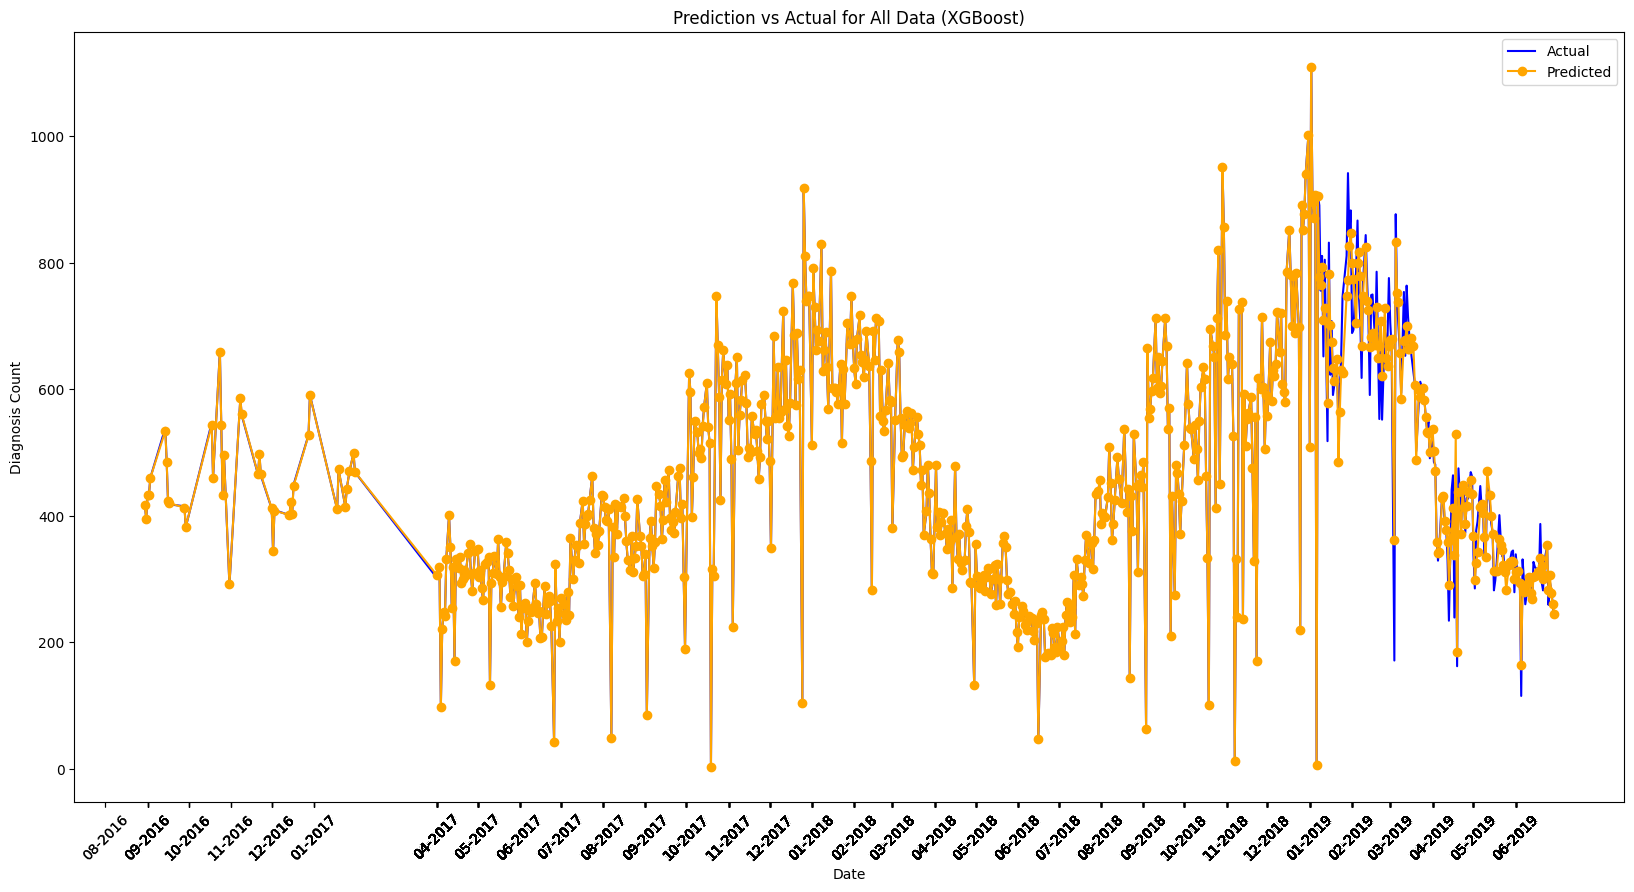

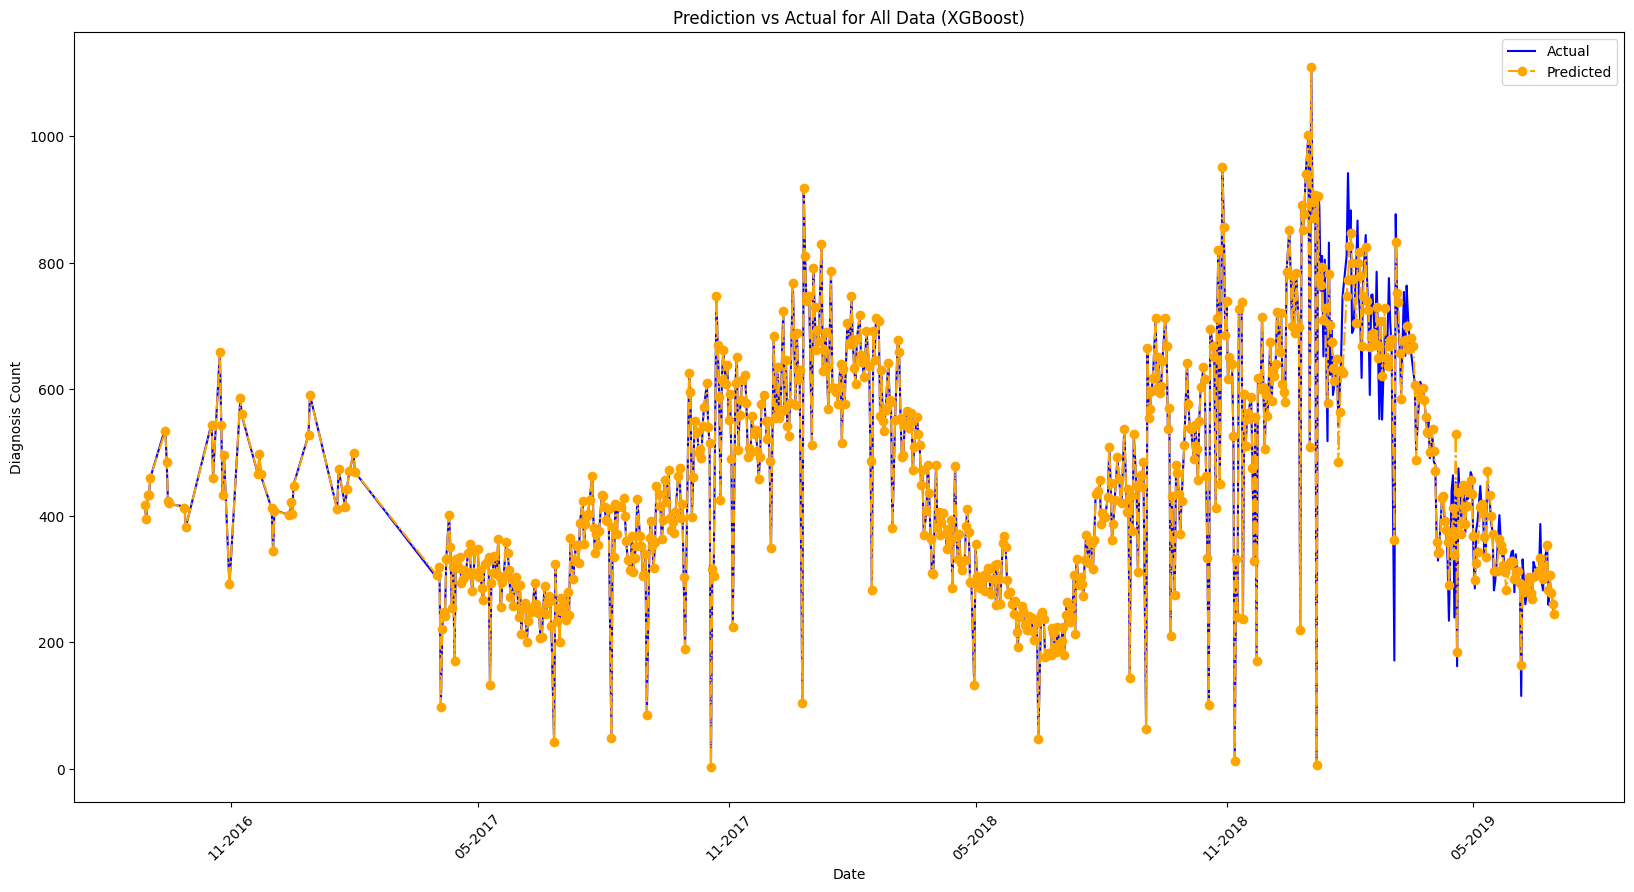

In [7]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# Preprocess data (same as before)
def preprocess_data(df):
    # Convert 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Aggregate by date: Count diagnoses per day
    time_series = df.groupby('date').agg({
        'diagnosis': 'count',  # Target: count diagnoses per day
        'age': 'mean',  # Average age
        'gender': 'mean'  # Average gender (proportion of males)
    }).reset_index()
    
    time_series.rename(columns={'diagnosis': 'diagnosis_count'}, inplace=True)
    
    # Extract temporal features
    time_series['month'] = time_series['date'].dt.month
    time_series['day_of_week'] = time_series['date'].dt.dayofweek
    time_series['season'] = (time_series['month'] % 12 // 3) + 1  # Winter(1), Spring(2), Summer(3), Autumn(4)
    
    # Create lag features
    for lag in range(1, 7):  # Lag features up to 6
        time_series[f'diagnosis_count_lag_{lag}'] = time_series['diagnosis_count'].shift(lag)
    
    # Add rolling averages
    time_series['rolling_mean_3'] = time_series['diagnosis_count'].rolling(window=3).mean()
    time_series['rolling_mean_7'] = time_series['diagnosis_count'].rolling(window=7).mean()
    
    # Drop rows with NaN values due to lagging/rolling
    time_series = time_series.dropna()
    
    return time_series

# Assuming df is already loaded as the dataset
# Preprocess the dataset
time_series = preprocess_data(df)

# Define features and target
features = ['age', 'gender', 'month', 'day_of_week', 'season'] + \
           [f'diagnosis_count_lag_{i}' for i in range(1, 7)] + \
           ['rolling_mean_3', 'rolling_mean_7']
X = time_series[features]
y = time_series['diagnosis_count']

# Train-test split (80% for training, 20% for testing)
train_size = int(len(time_series) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train XGBoost model
model = XGBRegressor(objective='reg:squarederror', n_estimators=300, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)

# Predictions for the test data
y_pred_test = model.predict(X_test)

# Predictions for all data (train + test)
y_pred_all = model.predict(X)

# Evaluate the model for test data
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

# Evaluate the model for all data
rmse_all = np.sqrt(mean_squared_error(y, y_pred_all))
r2_all = r2_score(y, y_pred_all)

# Print metrics
print(f"Test Data - RMSE: {rmse_test}, R²: {r2_test}")
print(f"All Data - RMSE: {rmse_all}, R²: {r2_all}")

# Plot Prediction vs Actual for Test Data
plt.figure(figsize=(18, 9))
plt.plot(time_series['date'][train_size:], y_test, label='Actual', color='blue')
plt.plot(time_series['date'][train_size:], y_pred_test, label='Predicted', color='orange', marker='o', linestyle='-')
plt.title('Prediction vs Actual for Test Data')
plt.xlabel('Date')
plt.ylabel('Diagnosis Count')
# Set x-axis labels to show only month-year
plt.xticks(time_series['date'][train_size:].dt.to_period('M').dt.to_timestamp(), 
           time_series['date'][train_size:].dt.to_period('M').dt.strftime('%m-%Y'), rotation=45)
plt.legend()
plt.show()

# Plot Prediction vs Actual for All Data
plt.figure(figsize=(20, 10))
plt.plot(time_series['date'], y, label='Actual', color='blue')
plt.plot(time_series['date'], y_pred_all, label='Predicted', color='orange', marker='o', linestyle='-')
plt.title('Prediction vs Actual for All Data (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Diagnosis Count')
# Set x-axis labels to show only month-year
plt.xticks(time_series['date'].dt.to_period('M').dt.to_timestamp(), 
           time_series['date'].dt.to_period('M').dt.strftime('%m-%Y'), rotation=45)
plt.legend()
plt.show

plt.figure(figsize=(20, 10))
plt.plot(time_series['date'], y, label='Actual', color='blue')
plt.plot(time_series['date'], y_pred_all, label='Predicted', color='orange', marker='o', linestyle='-.')
plt.title('Prediction vs Actual for All Data (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Diagnosis Count')

# Set x-axis ticks for every 6 months
locator = mdates.MonthLocator(interval=6)
formatter = mdates.DateFormatter('%m-%Y')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.legend()
plt.show()


Test Data - RMSE: 63.23843598947208, R²: 0.8933639685017598
All Data - RMSE: 35.44451501297479, R²: 0.9623053404439175


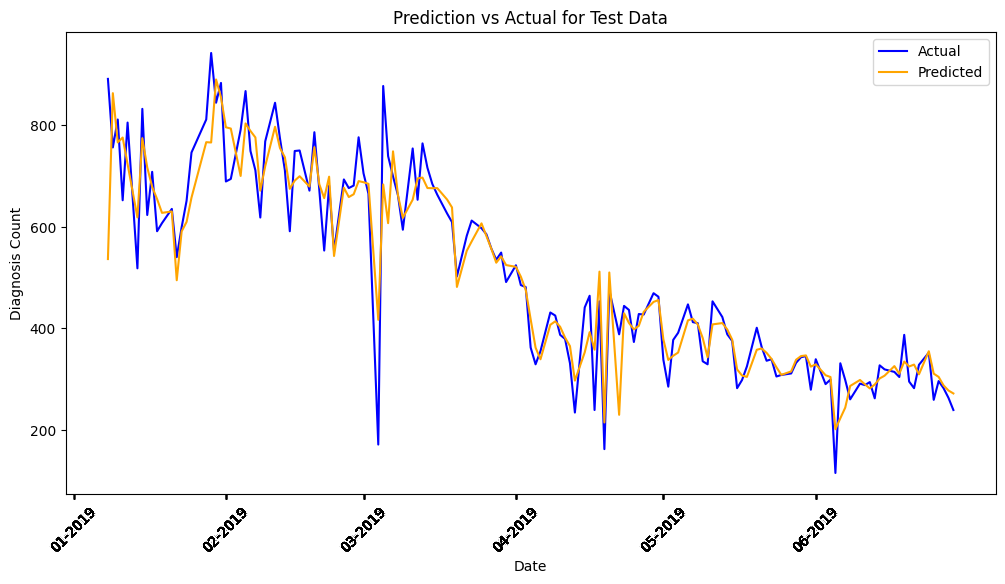

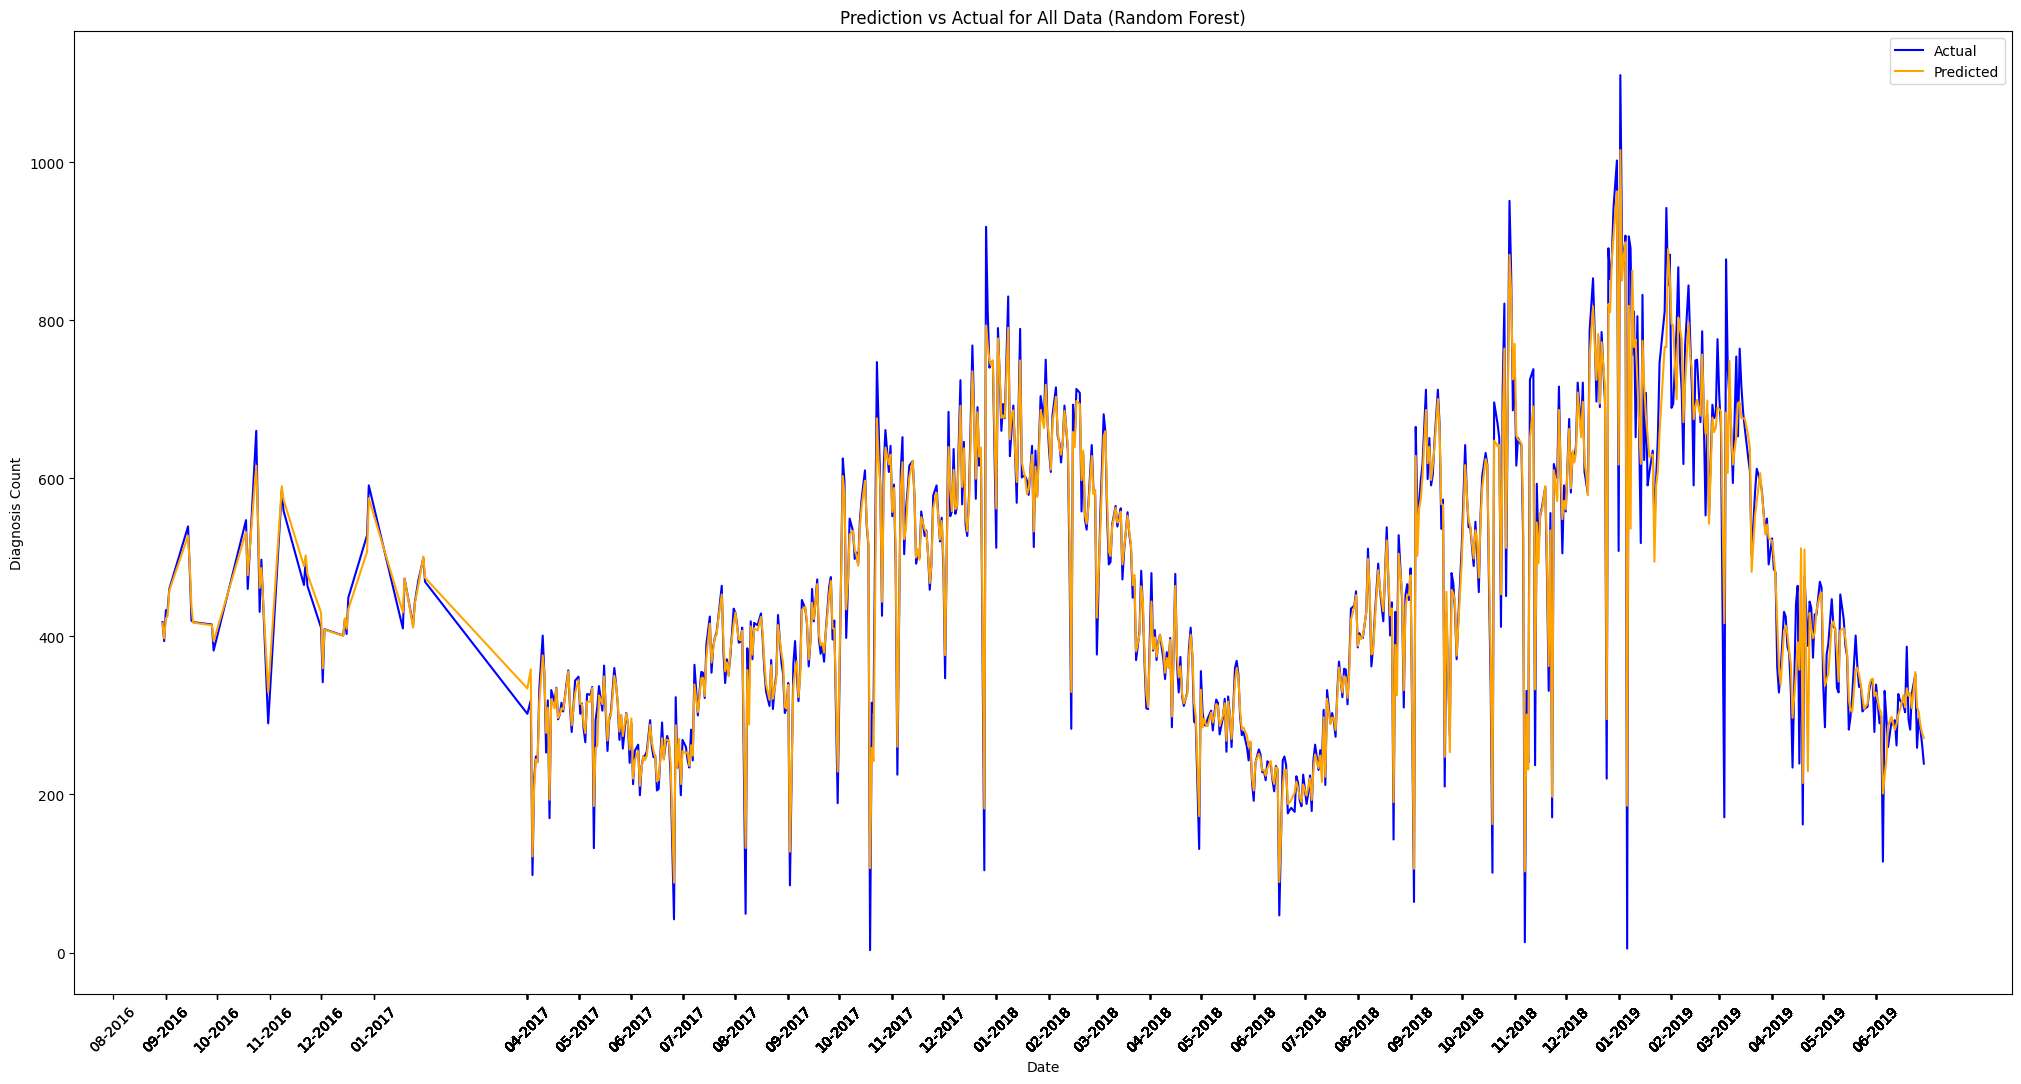

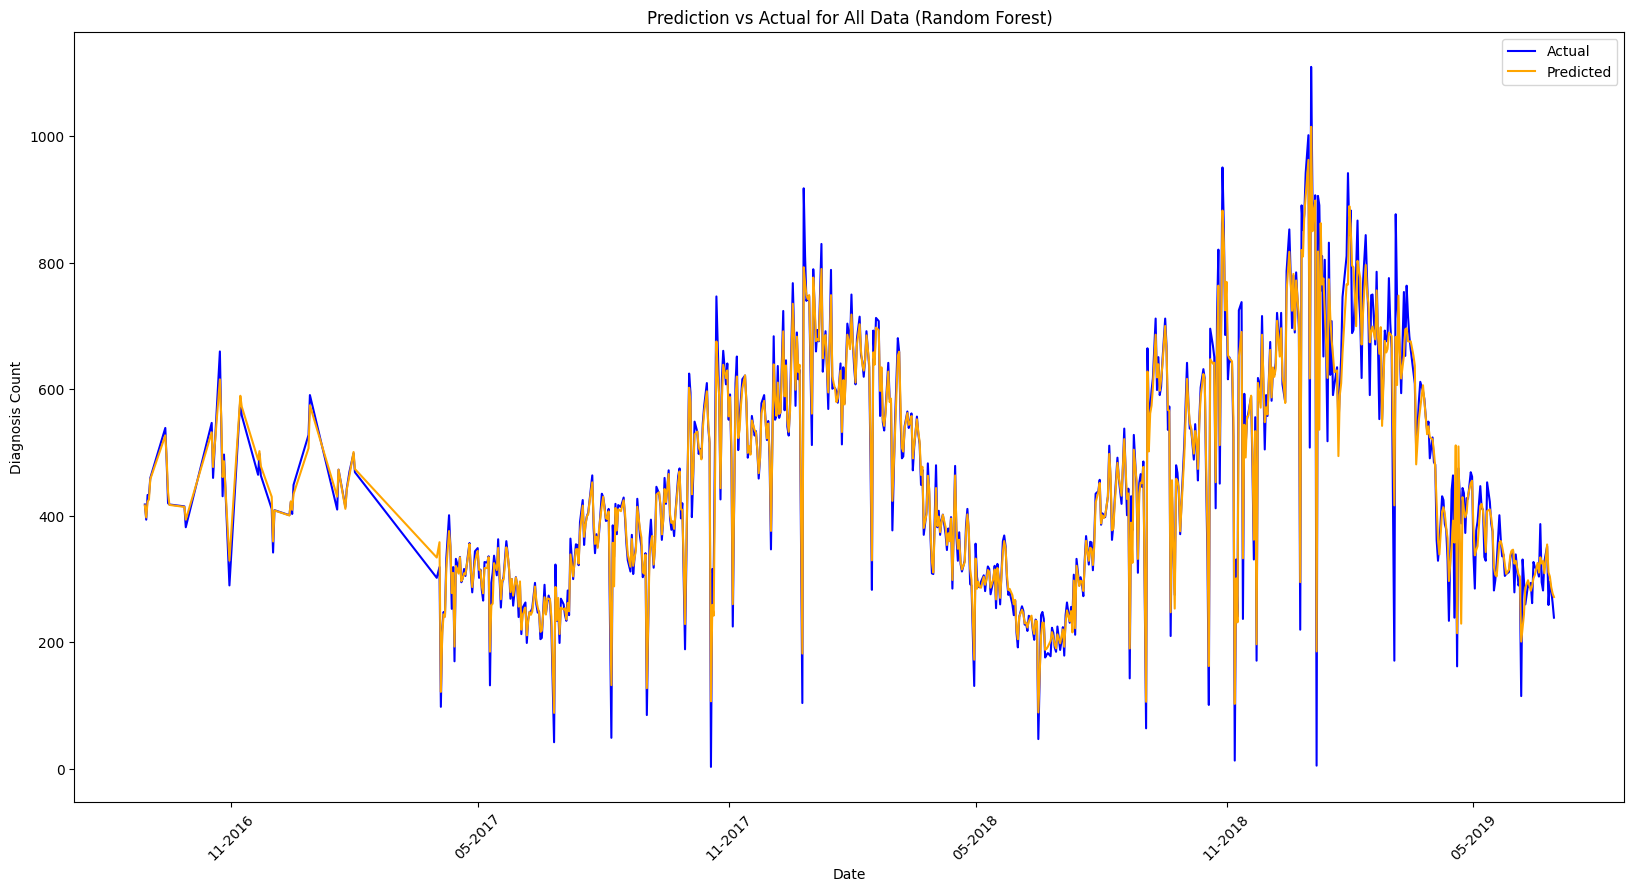

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Preprocess data (same as before)
def preprocess_data(df):
    # Convert 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Aggregate by date: Count diagnoses per day
    time_series = df.groupby('date').agg({
        'diagnosis': 'count',  # Target: count diagnoses per day
        'age': 'mean',  # Average age
        'gender': 'mean'  # Average gender (proportion of males)
    }).reset_index()
    
    time_series.rename(columns={'diagnosis': 'diagnosis_count'}, inplace=True)
    
    # Extract temporal features
    time_series['month'] = time_series['date'].dt.month
    time_series['day_of_week'] = time_series['date'].dt.dayofweek
    time_series['season'] = (time_series['month'] % 12 // 3) + 1  # Winter(1), Spring(2), Summer(3), Autumn(4)
    
    # Create lag features
    for lag in range(1, 7):  # Lag features up to 6
        time_series[f'diagnosis_count_lag_{lag}'] = time_series['diagnosis_count'].shift(lag)
    
    # Add rolling averages
    time_series['rolling_mean_3'] = time_series['diagnosis_count'].rolling(window=3).mean()
    time_series['rolling_mean_7'] = time_series['diagnosis_count'].rolling(window=7).mean()
    
    # Drop rows with NaN values due to lagging/rolling
    time_series = time_series.dropna()
    
    return time_series

# Assuming df is already loaded as the dataset
# Preprocess the dataset
time_series = preprocess_data(df)

# Define features and target
features = ['age', 'gender', 'month', 'day_of_week', 'season'] + \
           [f'diagnosis_count_lag_{i}' for i in range(1, 7)] + \
           ['rolling_mean_3', 'rolling_mean_7']
X = time_series[features]
y = time_series['diagnosis_count']

# Train-test split (80% for training, 20% for testing)
train_size = int(len(time_series) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train Random Forest model
model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

# Predictions for the test data
y_pred_test = model.predict(X_test)

# Predictions for all data (train + test)
y_pred_all = model.predict(X)

# Evaluate the model for test data
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

# Evaluate the model for all data
rmse_all = np.sqrt(mean_squared_error(y, y_pred_all))
r2_all = r2_score(y, y_pred_all)

# Print metrics
print(f"Test Data - RMSE: {rmse_test}, R²: {r2_test}")
print(f"All Data - RMSE: {rmse_all}, R²: {r2_all}")

# Plot Prediction vs Actual for Test Data
plt.figure(figsize=(12, 6))
plt.plot(time_series['date'][train_size:], y_test, label='Actual', color='blue')
plt.plot(time_series['date'][train_size:], y_pred_test, label='Predicted', color='orange')
plt.title('Prediction vs Actual for Test Data')
plt.xlabel('Date')
plt.ylabel('Diagnosis Count')
# Set x-axis labels to show only month-year
plt.xticks(time_series['date'][train_size:].dt.to_period('M').dt.to_timestamp(), 
           time_series['date'][train_size:].dt.to_period('M').dt.strftime('%m-%Y'), rotation=45)
plt.legend()
plt.show()

# Plot Prediction vs Actual for All Data
plt.figure(figsize=(25, 12.5))
plt.plot(time_series['date'], y, label='Actual', color='blue')
plt.plot(time_series['date'], y_pred_all, label='Predicted', color='orange')
plt.title('Prediction vs Actual for All Data (Random Forest)')
plt.xlabel('Date')
plt.ylabel('Diagnosis Count')
# Set x-axis labels to show only month-year
plt.xticks(time_series['date'].dt.to_period('M').dt.to_timestamp(), 
           time_series['date'].dt.to_period('M').dt.strftime('%m-%Y'), rotation=45)
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(time_series['date'], y, label='Actual', color='blue')
plt.plot(time_series['date'], y_pred_all, label='Predicted', color='orange')
plt.title('Prediction vs Actual for All Data (Random Forest)')
plt.xlabel('Date')
plt.ylabel('Diagnosis Count')

# Set x-axis ticks for every 6 months
locator = mdates.MonthLocator(interval=6)
formatter = mdates.DateFormatter('%m-%Y')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.legend()
plt.show()


Test Data - RMSE: 53.21524034421509, R²: 0.9244883796967115
All Data - RMSE: 26.850172995948657, R²: 0.9783690334792061


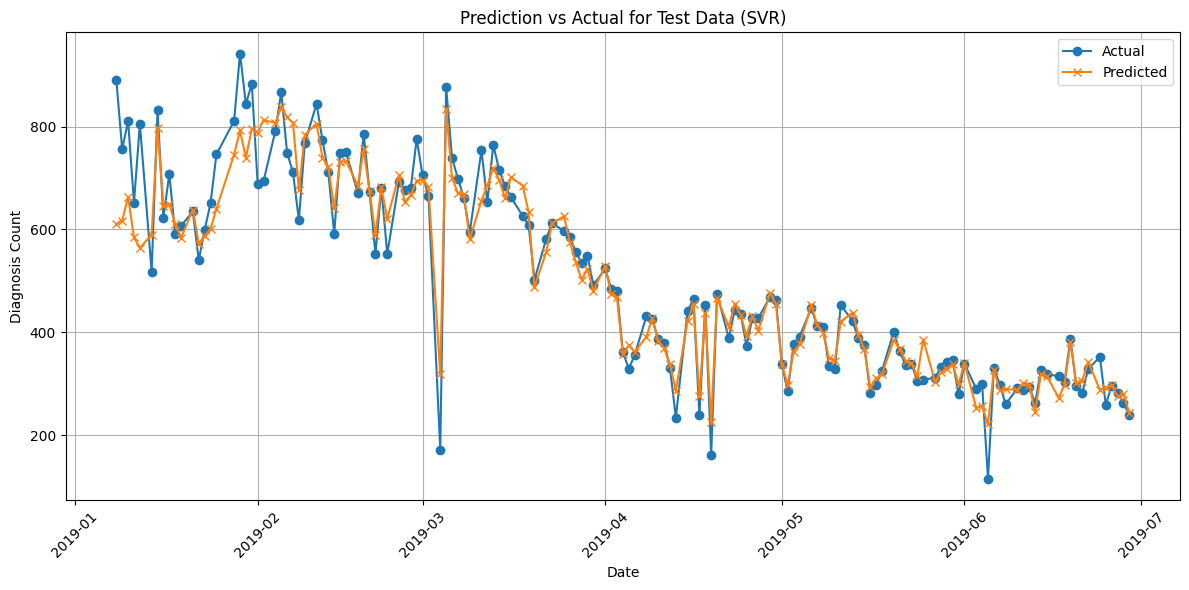

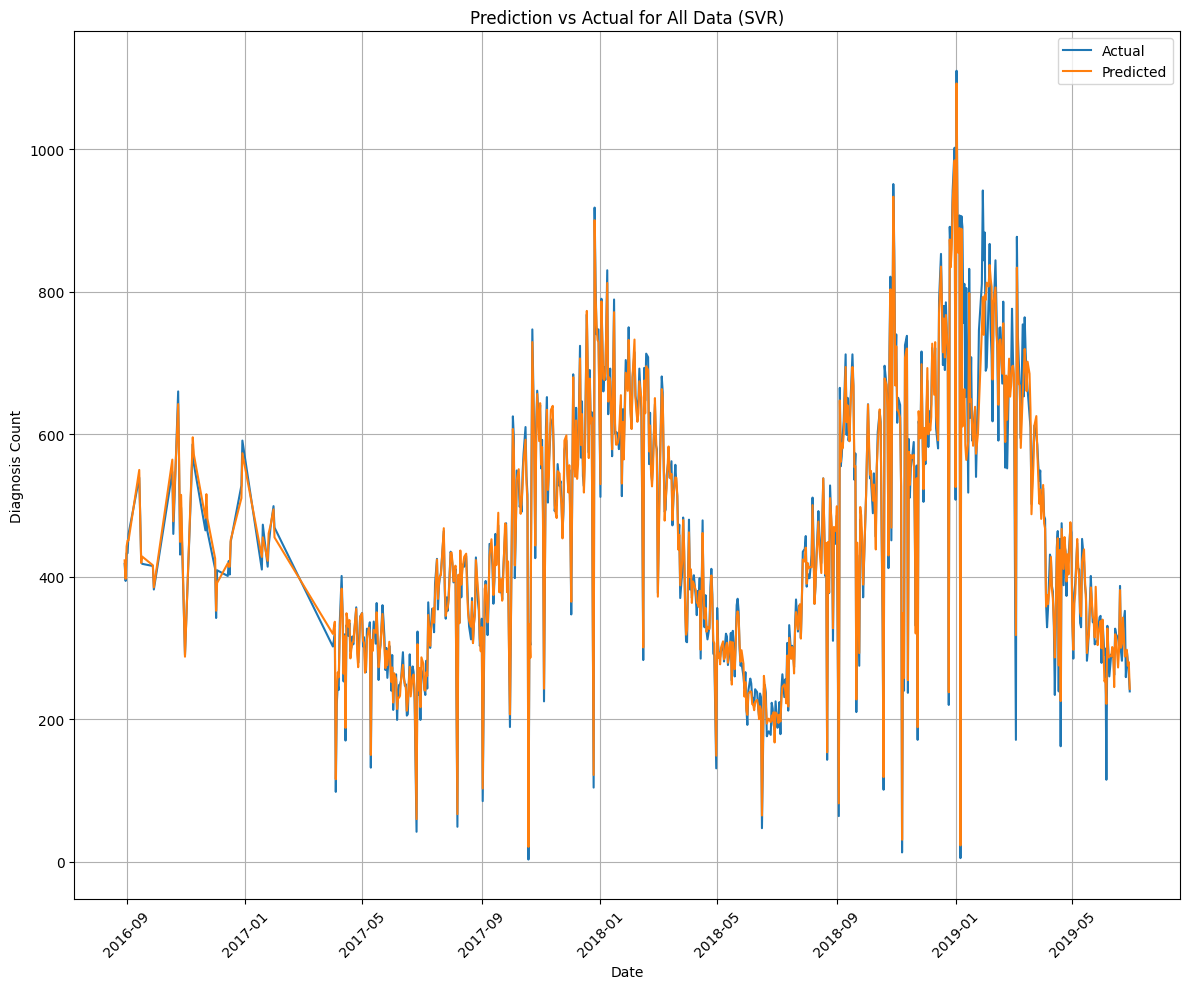

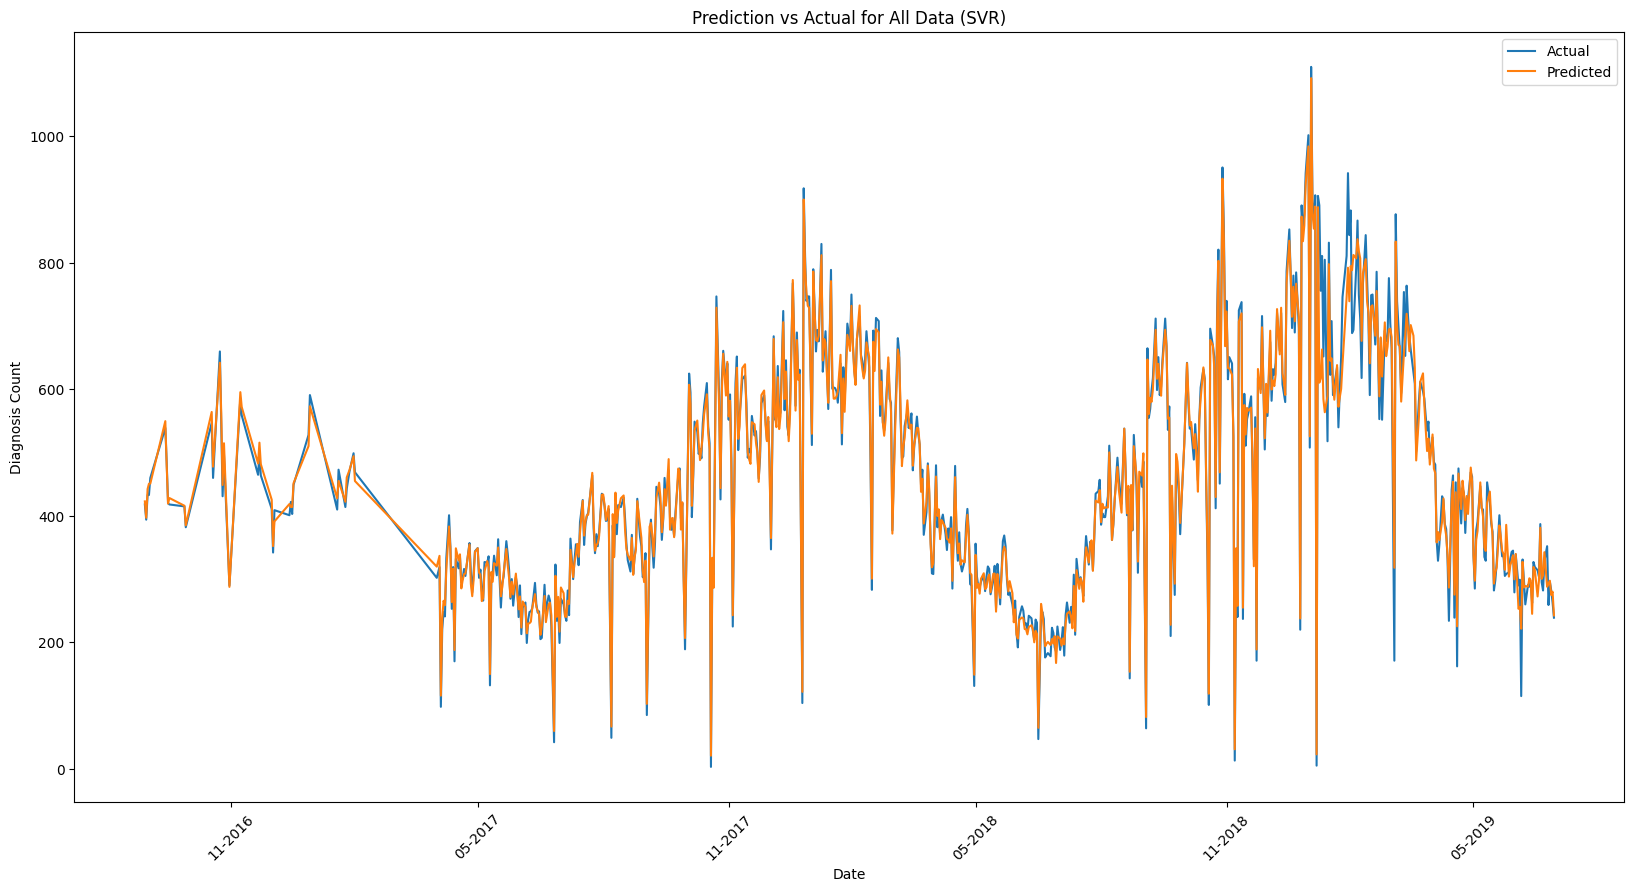

In [10]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Preprocess data
def preprocess_data(df):
    # Convert 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Aggregate by date: Count diagnoses per day
    time_series = df.groupby('date').agg({
        'diagnosis': 'count',  # Target: count diagnoses per day
        'age': 'mean',  # Average age
        'gender': 'mean'  # Average gender (proportion of males)
    }).reset_index()
    
    time_series.rename(columns={'diagnosis': 'diagnosis_count'}, inplace=True)
    
    # Extract temporal features
    time_series['month'] = time_series['date'].dt.month
    time_series['day_of_week'] = time_series['date'].dt.dayofweek
    time_series['season'] = (time_series['month'] % 12 // 3) + 1  # Winter(1), Spring(2), Summer(3), Autumn(4)
    
    # Create lag features
    for lag in range(1, 7):  # Lag features up to 6
        time_series[f'diagnosis_count_lag_{lag}'] = time_series['diagnosis_count'].shift(lag)
    
    # Add rolling averages
    time_series['rolling_mean_3'] = time_series['diagnosis_count'].rolling(window=3).mean()
    time_series['rolling_mean_7'] = time_series['diagnosis_count'].rolling(window=7).mean()
    
    # Drop rows with NaN values due to lagging/rolling
    time_series = time_series.dropna()
    return time_series

# Preprocess the dataset
time_series = preprocess_data(df)

# Define features and target
features = ['age', 'gender', 'month', 'day_of_week', 'season'] + \
           [f'diagnosis_count_lag_{i}' for i in range(1, 7)] + \
           ['rolling_mean_3', 'rolling_mean_7']
X = time_series[features]
y = time_series['diagnosis_count']

# Train-test split
train_size = int(len(time_series) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Feature Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Train SVR model
svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr.fit(X_train_scaled, y_train_scaled.ravel())

# Predictions
y_pred_scaled = svr.predict(X_test_scaled)

# Inverse scaling to get the original values
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))

# Evaluate the model for test data
rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_pred))
r2_test = r2_score(y_test_actual, y_pred)

# Predictions for all data (train + test)
y_pred_all_scaled = svr.predict(scaler_X.transform(X))
y_pred_all = scaler_y.inverse_transform(y_pred_all_scaled.reshape(-1, 1))

# Evaluate the model for all data
rmse_all = np.sqrt(mean_squared_error(y, y_pred_all))
r2_all = r2_score(y, y_pred_all)

# Print metrics for both test and all data
print(f"Test Data - RMSE: {rmse_test}, R²: {r2_test}")
print(f"All Data - RMSE: {rmse_all}, R²: {r2_all}")

# Plot Prediction vs Actual for Test Data
plt.figure(figsize=(12, 6))
plt.plot(time_series['date'][train_size:], y_test_actual, label='Actual', marker='o')
plt.plot(time_series['date'][train_size:], y_pred, label='Predicted', marker='x')
plt.title('Prediction vs Actual for Test Data (SVR)')
plt.xlabel('Date')
plt.ylabel('Diagnosis Count')
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Plot Prediction vs Actual for All Data
plt.figure(figsize=(12, 10))
plt.plot(time_series['date'], y, label='Actual')
plt.plot(time_series['date'], y_pred_all, label='Predicted')
plt.title('Prediction vs Actual for All Data (SVR)')
plt.xlabel('Date')
plt.ylabel('Diagnosis Count')
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(time_series['date'], y, label='Actual')
plt.plot(time_series['date'], y_pred_all, label='Predicted')
plt.title('Prediction vs Actual for All Data (SVR)')
plt.xlabel('Date')
plt.ylabel('Diagnosis Count')

# Set x-axis ticks for every 6 months
locator = mdates.MonthLocator(interval=6)
formatter = mdates.DateFormatter('%m-%Y')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.legend()
plt.show()


C:\Users\vidhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\basic.py:357: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1967
[LightGBM] [Info] Number of data points in the train set: 587, number of used features: 13
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

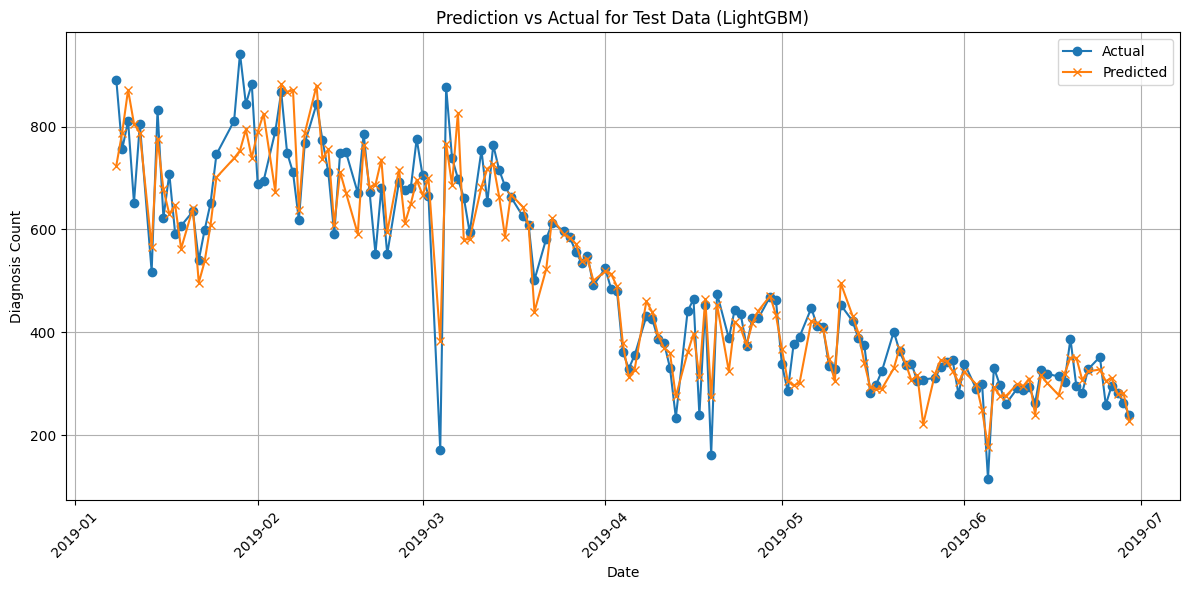

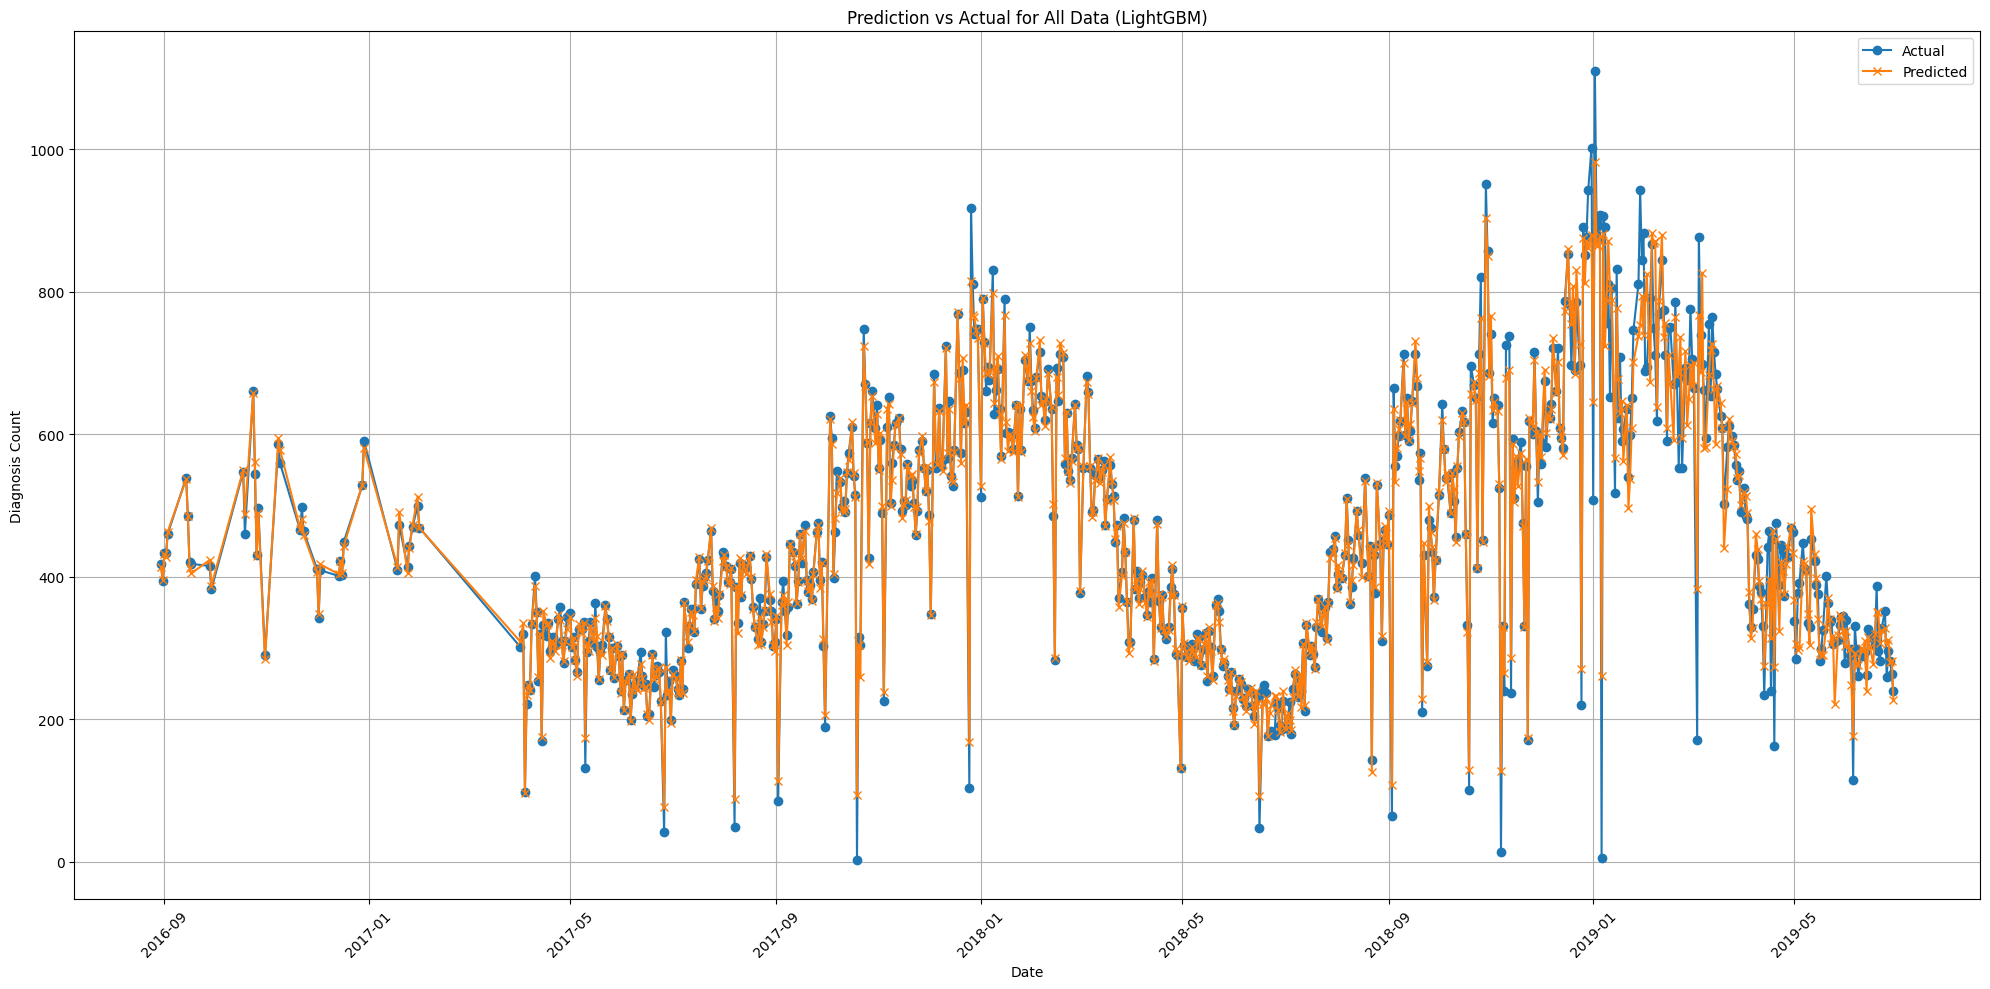

In [16]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Preprocess data
def preprocess_data(df):
    # Convert 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Aggregate by date: Count diagnoses per day
    time_series = df.groupby('date').agg({
        'diagnosis': 'count',  # Target: count diagnoses per day
        'age': 'mean',  # Average age
        'gender': 'mean'  # Average gender (proportion of males)
    }).reset_index()
    
    time_series.rename(columns={'diagnosis': 'diagnosis_count'}, inplace=True)
    
    # Extract temporal features
    time_series['month'] = time_series['date'].dt.month
    time_series['day_of_week'] = time_series['date'].dt.dayofweek
    time_series['season'] = (time_series['month'] % 12 // 3) + 1  # Winter(1), Spring(2), Summer(3), Autumn(4)
    
    # Create lag features
    for lag in range(1, 7):  # Lag features up to 6
        time_series[f'diagnosis_count_lag_{lag}'] = time_series['diagnosis_count'].shift(lag)
    
    # Add rolling averages
    time_series['rolling_mean_3'] = time_series['diagnosis_count'].rolling(window=3).mean()
    time_series['rolling_mean_7'] = time_series['diagnosis_count'].rolling(window=7).mean()
    
    # Drop rows with NaN values due to lagging/rolling
    time_series = time_series.dropna()
    return time_series

# Preprocess the dataset
time_series = preprocess_data(df)

# Define features and target
features = ['age', 'gender', 'month', 'day_of_week', 'season'] + \
           [f'diagnosis_count_lag_{i}' for i in range(1, 7)] + \
           ['rolling_mean_3', 'rolling_mean_7']
X = time_series[features]
y = time_series['diagnosis_count']

# Train-test split
train_size = int(len(time_series) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Feature Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Train LightGBM model
train_data = lgb.Dataset(X_train_scaled, label=y_train_scaled)
params = {
    'objective': 'regression',
    'metric': 'rmse',  # Root Mean Squared Error
    'boosting_type': 'gbdt',
    'num_leaves': 31,  # Number of leaves in one tree
    'learning_rate': 0.1,
    'feature_fraction': 0.9
}

# Train the model
lgb_model = lgb.train(params, train_data, num_boost_round=100)

# Predictions for test data
y_pred_scaled = lgb_model.predict(X_test_scaled)

# Inverse scaling to get the original values
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))

# Evaluate the model for test data
rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_pred))
r2_test = r2_score(y_test_actual, y_pred)

# Predictions for all data (train + test)
y_pred_all_scaled = lgb_model.predict(scaler_X.transform(X))
y_pred_all = scaler_y.inverse_transform(y_pred_all_scaled.reshape(-1, 1))

# Evaluate the model for all data
rmse_all = np.sqrt(mean_squared_error(y, y_pred_all))
r2_all = r2_score(y, y_pred_all)

# Print metrics for both test and all data
print(f"Test Data - RMSE: {rmse_test}, R²: {r2_test}")
print(f"All Data - RMSE: {rmse_all}, R²: {r2_all}")

# Plot Prediction vs Actual for Test Data
plt.figure(figsize=(12, 6))
plt.plot(time_series['date'][train_size:], y_test_actual, label='Actual', marker='o')
plt.plot(time_series['date'][train_size:], y_pred, label='Predicted', marker='x')
plt.title('Prediction vs Actual for Test Data (LightGBM)')
plt.xlabel('Date')
plt.ylabel('Diagnosis Count')
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Plot Prediction vs Actual for All Data
plt.figure(figsize=(20, 10))
plt.plot(time_series['date'], y, label='Actual', marker='o')
plt.plot(time_series['date'], y_pred_all, label='Predicted', marker='x')
plt.title('Prediction vs Actual for All Data (LightGBM)')
plt.xlabel('Date')
plt.ylabel('Diagnosis Count')
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


C:\Users\vidhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightgbm\basic.py:357: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1967
[LightGBM] [Info] Number of data points in the train set: 587, number of used features: 13
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

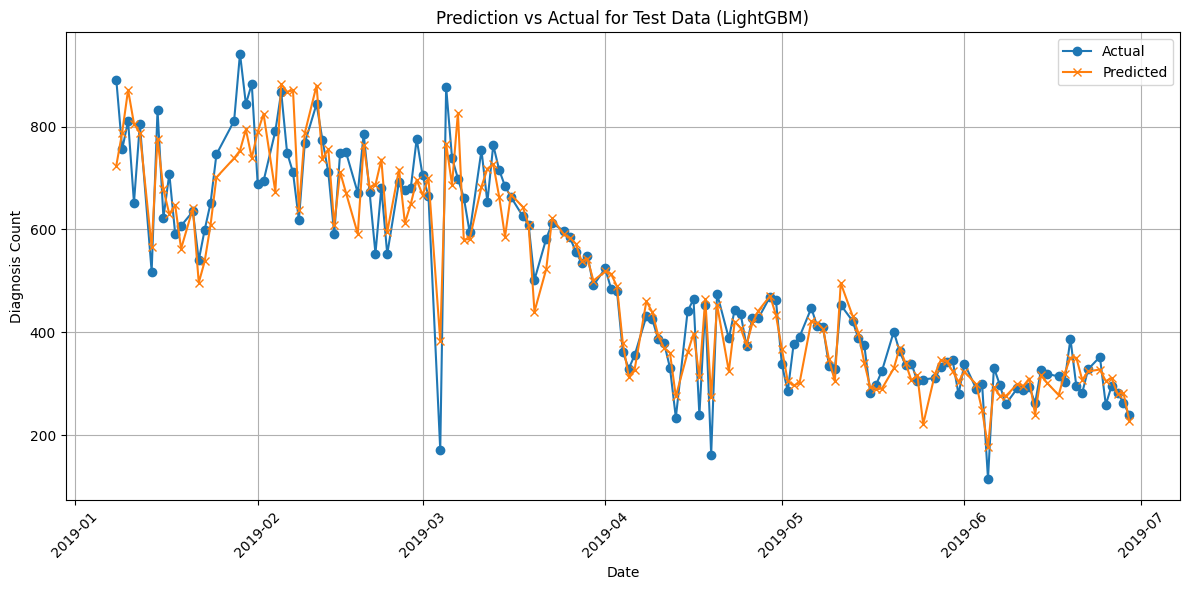

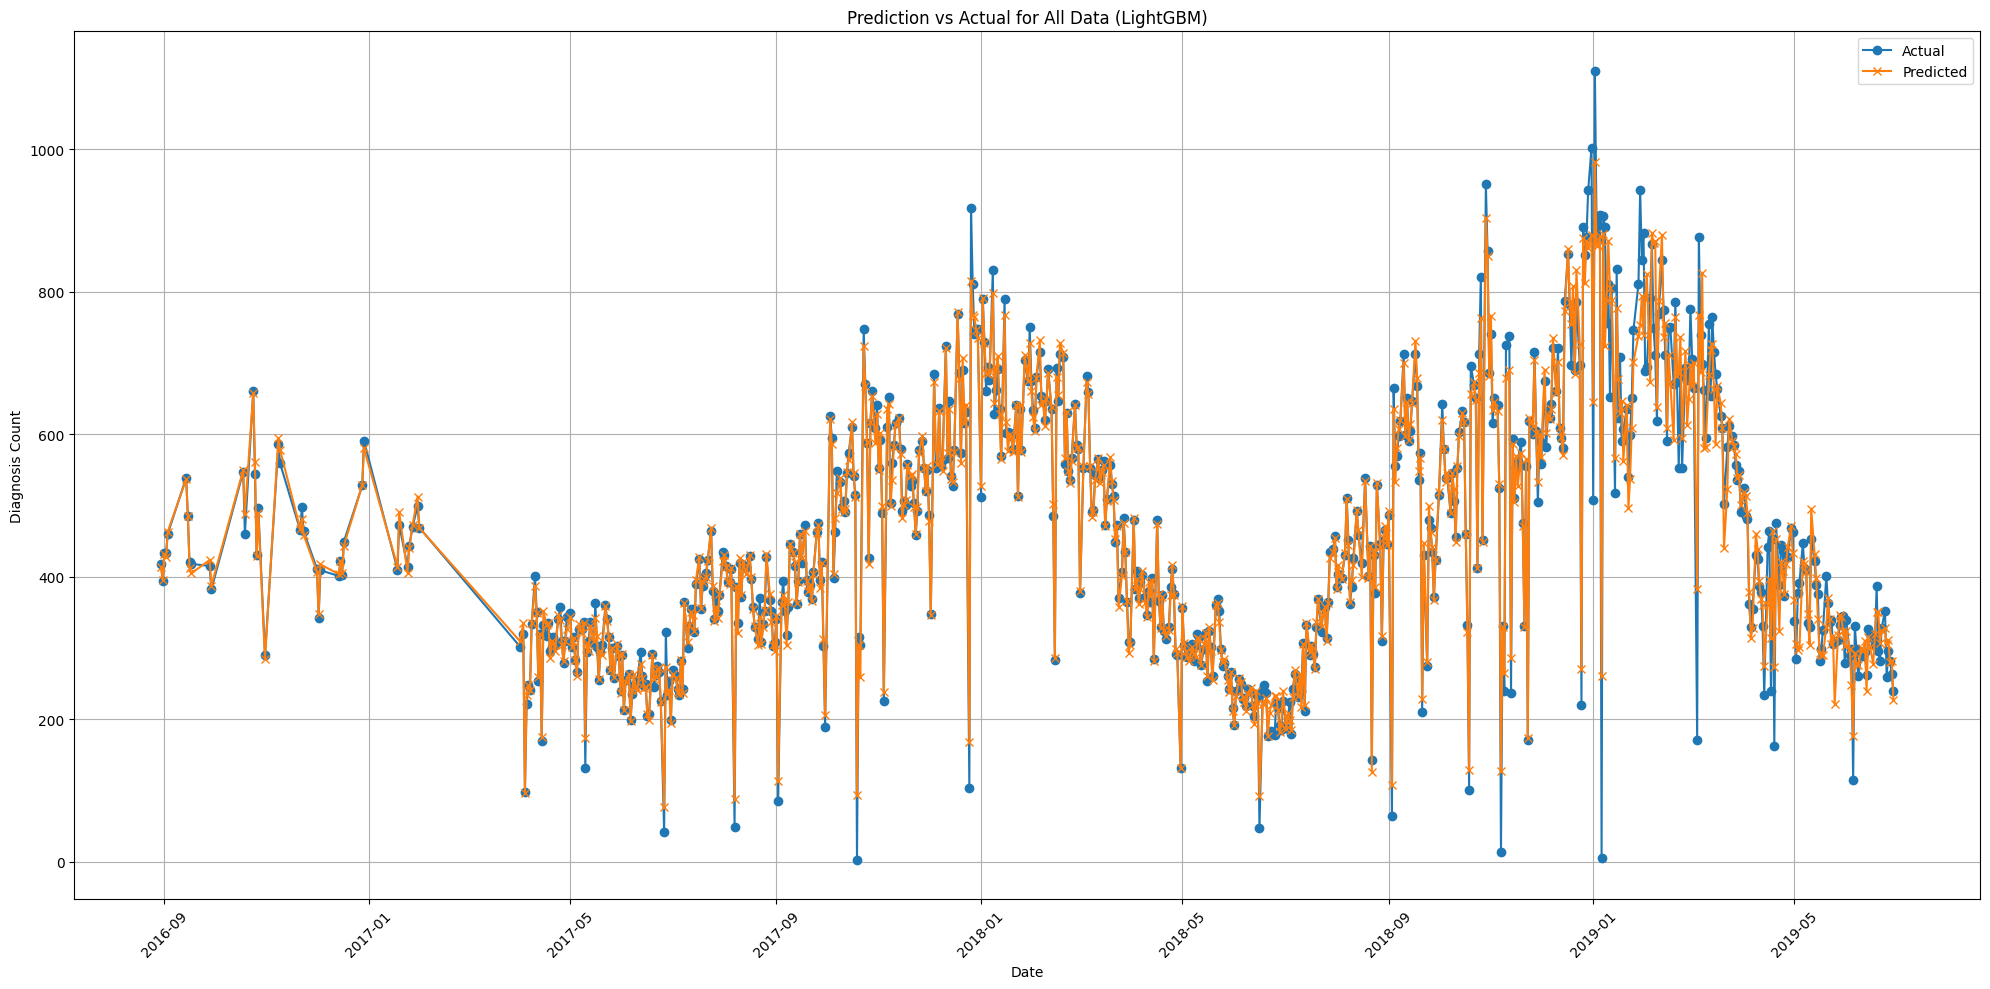

In [17]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Preprocess data
def preprocess_data(df):
    # Convert 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Aggregate by date: Count diagnoses per day
    time_series = df.groupby('date').agg({
        'diagnosis': 'count',  # Target: count diagnoses per day
        'age': 'mean',  # Average age
        'gender': 'mean'  # Average gender (proportion of males)
    }).reset_index()
    
    time_series.rename(columns={'diagnosis': 'diagnosis_count'}, inplace=True)
    
    # Extract temporal features
    time_series['month'] = time_series['date'].dt.month
    time_series['day_of_week'] = time_series['date'].dt.dayofweek
    time_series['season'] = (time_series['month'] % 12 // 3) + 1  # Winter(1), Spring(2), Summer(3), Autumn(4)
    
    # Create lag features
    for lag in range(1, 7):  # Lag features up to 6
        time_series[f'diagnosis_count_lag_{lag}'] = time_series['diagnosis_count'].shift(lag)
    
    # Add rolling averages
    time_series['rolling_mean_3'] = time_series['diagnosis_count'].rolling(window=3).mean()
    time_series['rolling_mean_7'] = time_series['diagnosis_count'].rolling(window=7).mean()
    
    # Drop rows with NaN values due to lagging/rolling
    time_series = time_series.dropna()
    return time_series

# Preprocess the dataset
time_series = preprocess_data(df)

# Define features and target
features = ['age', 'gender', 'month', 'day_of_week', 'season'] + \
           [f'diagnosis_count_lag_{i}' for i in range(1, 7)] + \
           ['rolling_mean_3', 'rolling_mean_7']
X = time_series[features]
y = time_series['diagnosis_count']

# Train-test split
train_size = int(len(time_series) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Feature Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Train LightGBM model
train_data = lgb.Dataset(X_train_scaled, label=y_train_scaled)
params = {
    'objective': 'regression',
    'metric': 'rmse',  # Root Mean Squared Error
    'boosting_type': 'gbdt',
    'num_leaves': 31,  # Number of leaves in one tree
    'learning_rate': 0.1,
    'feature_fraction': 0.9
}

# Train the model
lgb_model = lgb.train(params, train_data, num_boost_round=100)

# Predictions for test data
y_pred_scaled = lgb_model.predict(X_test_scaled)

# Inverse scaling to get the original values
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))

# Evaluate the model for test data
rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_pred))
r2_test = r2_score(y_test_actual, y_pred)

# Predictions for all data (train + test)
y_pred_all_scaled = lgb_model.predict(scaler_X.transform(X))
y_pred_all = scaler_y.inverse_transform(y_pred_all_scaled.reshape(-1, 1))

# Evaluate the model for all data
rmse_all = np.sqrt(mean_squared_error(y, y_pred_all))
r2_all = r2_score(y, y_pred_all)

# Print metrics for both test and all data
print(f"Test Data - RMSE: {rmse_test}, R²: {r2_test}")
print(f"All Data - RMSE: {rmse_all}, R²: {r2_all}")

# Plot Prediction vs Actual for Test Data
plt.figure(figsize=(12, 6))
plt.plot(time_series['date'][train_size:], y_test_actual, label='Actual', marker='o')
plt.plot(time_series['date'][train_size:], y_pred, label='Predicted', marker='x')
plt.title('Prediction vs Actual for Test Data (LightGBM)')
plt.xlabel('Date')
plt.ylabel('Diagnosis Count')
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Plot Prediction vs Actual for All Data
plt.figure(figsize=(20, 10))
plt.plot(time_series['date'], y, label='Actual', marker='o')
plt.plot(time_series['date'], y_pred_all, label='Predicted', marker='x')
plt.title('Prediction vs Actual for All Data (LightGBM)')
plt.xlabel('Date')
plt.ylabel('Diagnosis Count')
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()
